## 1-Parameter Estimation
Parameter estimation following this [tutorial](https://docs.sciml.ai/DiffEqParamEstim/stable/getting_started/)

In [10]:
using Pkg
Pkg.activate("../../PINN")

using DifferentialEquations, RecursiveArrayTools, DiffEqParamEstim
using Optimization, ForwardDiff, OptimizationOptimJL, OptimizationBBO
using Plots

  Activating project at `~/SURE2023/scientific_julia/jen`


In [11]:
# ode system with parameter p
function sys(du,u,p,t)
    du[1] = -u[1] + p[1]*u[3]
    du[2] = -u[2] + 2*u[3]
    du[3] = u[1]^2 - 2*u[3]
end

# initial conditions
u0 = [1,1/2,3]
# timespan
tspan = (0.0,1.5)

(0.0, 1.5)

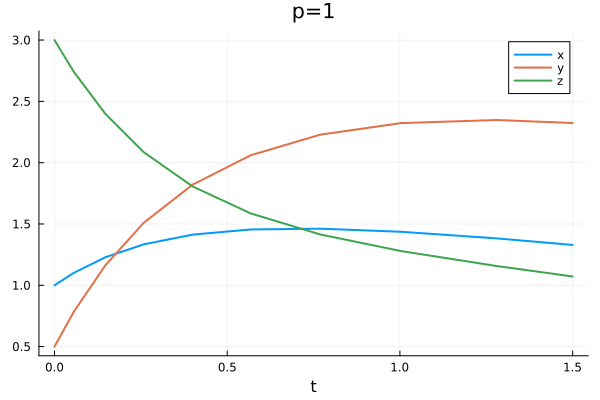

In [12]:
# first we solve the system with a unique parameter value, ps
# parameter space
ps = 1
prob = ODEProblem(sys,u0,tspan,ps)
sol = solve(prob,Tsit5())
solution = reduce(vcat,sol.u')
# visualize the solution
plot(sol.t, [solution[:,1] solution[:,2] solution[:,3]],
     linewidth=2, label=["x" "y" "z"], title="p=$ps", xlabel="t")


In [13]:
# we generate synthetic data using this solution (p value above)
t = collect(range(0,stop=1.5,length=200))
randomized = VectorOfArray([(sol(t[i]) + .01randn(3)) for i in eachindex(t)])
data = convert(Array,randomized)

3×200 Matrix{Float64}:
 0.99463   1.03204   1.01528  1.05082   …  1.34109  1.34085  1.32856  1.35093
 0.504725  0.545772  0.55722  0.643755     2.34499  2.33643  2.31555  2.31973
 3.00589   2.96116   2.93386  2.87117      1.07718  1.07285  1.07119  1.07543

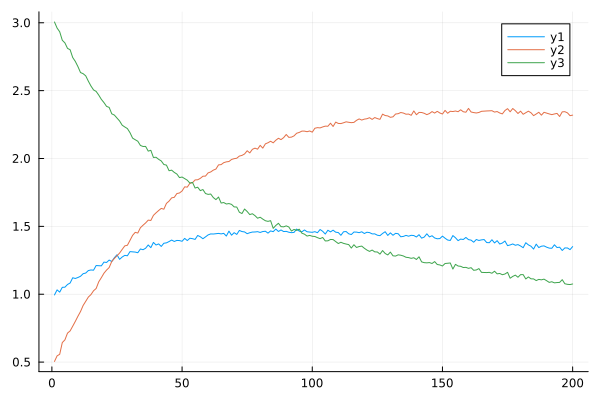

In [14]:
# Visualizing synthetic data
plot(data[1, :])
plot!(data[2, :])
plot!(data[3, :])

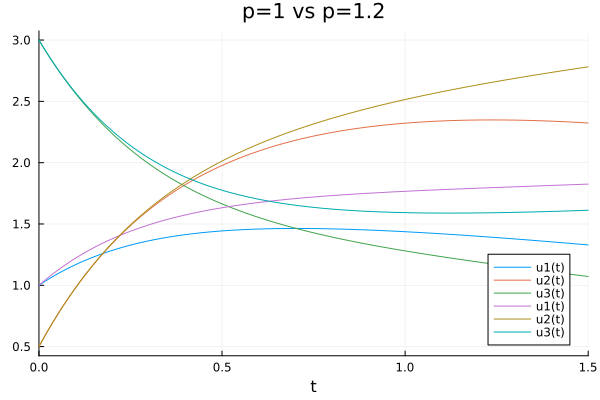

In [15]:
# redefine the prob with a new parameter
newprob = remake(prob, p=1.2)
newsol = solve(newprob,Tsit5())
# visualize the two solutions together
plot(sol, title="p=1 vs p=1.2")
plot!(newsol)

`build_loss_objective` builds an objective function to be used with Optim.jl

`function build_loss_objective`

            (prob::DEProblem, alg, loss,
                                    adtype = SciMLBase.NoAD(),
                                    regularization = nothing;
                                    priors = nothing,
                                    prob_generator = STANDARD_PROB_GENERATOR,
                                    kwargs...)

- First argument is the `DEProblem` to solve
- Next is the algorithm to use, which must match the problem type
- `regularization` defaults to nothing

Internally, this objective function is calling the ODE solver to get solutions to test against the data.

- `maxiters` is set in a way that causes the DE solvers to error more quickly when in bad regions of the parameter space (speeds up the process)
    - if the integrator stops early, given infinite loss
- `verbose=false` because this can get noisy
- `Optimization.AutoForwardDIff()` is a choice of automatic differentiation (how gradients are calculated)

In [16]:
# define an objective (cost) function for optimization
cost_function = build_loss_objective(prob, Tsit5(), L2Loss(t,data),
                                     Optimization.AutoForwardDiff(),
                                     maxiters=10000,verbose=false)


(::OptimizationFunction{true, Optimization.AutoForwardDiff{nothing}, DiffEqParamEstim.var"#29#30"{Nothing, typeof(DiffEqParamEstim.STANDARD_PROB_GENERATOR), Base.Pairs{Symbol, Integer, Tuple{Symbol, Symbol}, NamedTuple{(:maxiters, :verbose), Tuple{Int64, Bool}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Int64, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(sys), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, L2Loss{Vector{Float64}, Matrix{Float64}, Nothing, Nothing, Nothing}, Nothing, Tuple{}}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typ

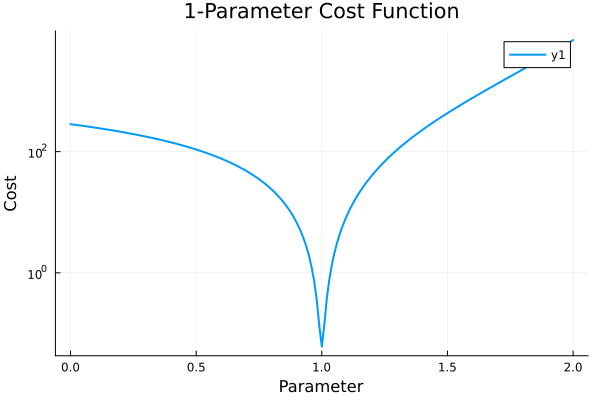

In [17]:
# test the parameter space [0,2] with the cost_function
param_space = 0.0:0.01:2
cost = [cost_function(i) for i in param_space]
# visualize the 
plot(param_space, cost, yscale=:log10, xlabel="Parameter",
     ylabel="Cost", title="1-Parameter Cost Function", lw=2)

Well-defined minimum in the cost function at the real parameter, which we set to be `ps=1`.

Can now use the `BFGS` algorithm to optimize the parameter starting at `p=1.2`. We do this by creating an optimization problem and solving that with `BFGS()`.

In [18]:
optprob = Optimization.OptimizationProblem(cost_function, [1.2])
optsol = solve(optprob, BFGS())

u: 1-element Vector{Float64}:
 0.9998562420293654

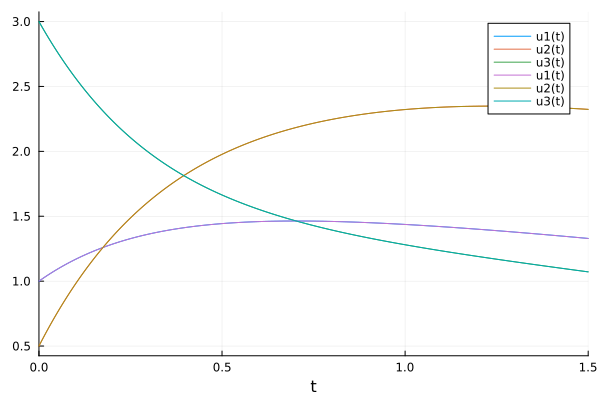

In [19]:
# Visualizing performance
newprob = remake(prob, p = optsol.u)
newsol = solve(newprob, Tsit5())
plot(sol)
plot!(newsol)

## Multiple Parameter Estimation
All parameters free.

In [20]:
# Defining new ODE system
function sys(du,u,p,t)
    du[1] = p[1]*u[1] + p[2]*u[3]
    du[2] = p[3]*u[2] + p[4]*u[3]
    du[3] = p[5]*u[1]^2 + p[6]*u[3]
end

# initial conditions
u0 = [1,1/2,3]
# timespan
tspan = (0.0,1.5)

(0.0, 1.5)

In [30]:
# Assigning random parameter values
ps = [-0.5,0.5,-1.5,1.6,1.3,-1.6]
prob = ODEProblem(sys,u0,tspan,ps)

# Building objective function
cost_function = build_loss_objective(prob, Tsit5(), L2Loss(t, data), 
                                    Optimization.AutoForwardDiff(),
                                    maxiters=10000, verbose=false)
optprob = Optimization.OptimizationProblem(cost_function, [-0.9,0.8,-1.3,1.6,1.3,-1.6])
sol = solve(optprob, BFGS())

u: 6-element Vector{Float64}:
 -1.0088834539042693
  1.007330257365975
 -1.000228944022209
  1.9985443049134788
  0.9986043546873385
 -1.9996882842188517

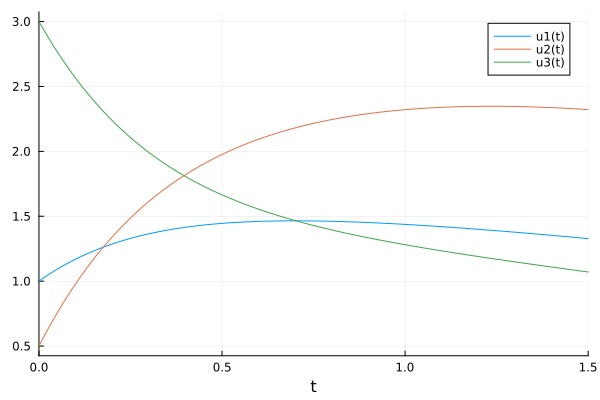

In [28]:
# Visualizing performance
newprob = remake(prob, p = sol.u)
newsol = solve(newprob, Tsit5())
plot(newsol)

However, this method is sensitive and depends on the initial guess.